In [1]:
from scripts._common import *

log = logging.getLogger(__name__)

from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.legend
import numpy as np
import seaborn as sns

from src.clip_eval import eval_single_dataset
from src.task_vectors import TaskVector

TEST_DATASET = ["SUN397", "Cars", "RESISC45", "EuroSAT", "SVHN", "GTSRB", "MNIST", "DTD"]

sns.set_theme(style="darkgrid")
color_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
# sns.set_palette("bright")

# 设置全局字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

add task arithmetic as step 0

In [2]:
def b32_add_step_0_data(df: pd.DataFrame):
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "step": [0],
                    "SUN397": [55.3 * 0.01],
                    "Cars": [54.9 * 0.01],
                    "RESISC45": [66.7 * 0.01],
                    "EuroSAT": [77.4 * 0.01],
                    "SVHN": [80.2 * 0.01],
                    "GTSRB": [69.7 * 0.01],
                    "MNIST": [97.3 * 0.01],
                    "DTD": [50.1 * 0.01],
                },
            ),
        ]
    )
    return df


def l14_add_step_0_data(df: pd.DataFrame):
    # 82.1 65.6 92.6 86.8 98.9 86.7 74.1 87.9
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "step": [0],
                    "SUN397": [82.1 * 0.01],
                    "Cars": [65.6 * 0.01],
                    "RESISC45": [92.6 * 0.01],
                    "EuroSAT": [86.8 * 0.01],
                    "SVHN": [98.9 * 0.01],
                    "GTSRB": [86.7 * 0.01],
                    "MNIST": [74.1 * 0.01],
                    "DTD": [87.9 * 0.01],
                },
            ),
        ]
    )
    return df

In [3]:
def set_corruption(df, corruption: str):
    if corruption == "None":
        df["corruption"] = "Clean"
    elif corruption == "motion_blur":
        df["corruption"] = "Motion Blur"
    elif corruption == "impulse_noise":
        df["corruption"] = "Impluse Noise"
    elif corruption == "gaussian_noise":
        df["corruption"] = "Gaussian Noise"
    elif corruption == "pixelate":
        df["corruption"] = "Pixelate"
    elif corruption == "spatter":
        df["corruption"] = "Spatter"
    elif corruption == "contrast":
        df["corruption"] = "Contrast"
    elif corruption == "jpeg_compression":
        df["corruption"] = "JPEG Compression"
    else:
        raise ValueError

# Model Fusion

In [30]:
b32fusion_data = []
_data = pd.read_csv("results/clip_dictmoe/ViT-B-32/version_0/results.csv")
_data = b32_add_step_0_data(_data)
_data["lr"] = "1e-3"
b32fusion_data.append(_data)
_data = pd.read_csv("results/clip_dictmoe/ViT-B-32/version_1/results.csv")
_data = b32_add_step_0_data(_data)
_data["lr"] = "1e-4"
b32fusion_data.append(_data)
_data = pd.read_csv("results/clip_dictmoe/ViT-B-32/version_2/results.csv")
_data = b32_add_step_0_data(_data)
_data["lr"] = "5e-5"
b32fusion_data.append(_data)

b32fusion_data = pd.concat(b32fusion_data)
b32fusion_data_melted = b32fusion_data.melt(
    id_vars=["lr", "step"],
    value_vars=["SUN397", "Cars", "RESISC45", "EuroSAT", "SVHN", "GTSRB", "MNIST", "DTD"],
    var_name="Tasks",
    value_name="Accuracy",
)

In [31]:
l14fusion_data = []
_data = pd.read_csv("results/clip_dictmoe/ViT-L-14/version_1/results.csv")
_data = l14_add_step_0_data(_data)
_data["lr"] = "1e-3"
l14fusion_data.append(_data)

l14fusion_data = pd.concat(l14fusion_data)
l14fusion_data_melted = l14fusion_data.melt(
    id_vars=["lr", "step"],
    value_vars=["SUN397", "Cars", "RESISC45", "EuroSAT", "SVHN", "GTSRB", "MNIST", "DTD"],
    var_name="Tasks",
    value_name="Accuracy",
)

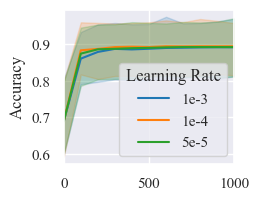

In [63]:
fig, ax = plt.subplots(figsize=(2.2, 2))
g = sns.lineplot(b32fusion_data_melted, x="step", y="Accuracy", hue="lr", palette=color_palette[:3], ax=ax)
g.legend_.set_title("Learning Rate")
ax.set_xlim((0, 1000))
ax.set_xlabel("")

plt.savefig("b32_acc.pdf", bbox_inches="tight")
plt.show()

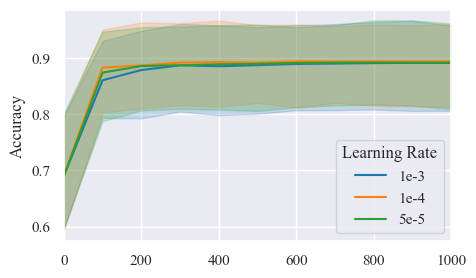

In [38]:
fig, ax = plt.subplots(figsize=(5, 3))
g = sns.lineplot(
    b32fusion_data_melted,
    x="step",
    y="Accuracy",
    hue="lr",
    palette=color_palette[:3],
    ax=ax,
)
g.legend_.set_title("Learning Rate")
g.legend_.set(loc='lower right')
ax.set_xlim((0, 1000))
ax.set_xlabel("")

plt.savefig("b32_acc_large.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_2570621/268208335.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data["Model"] = "ViT-B-32"


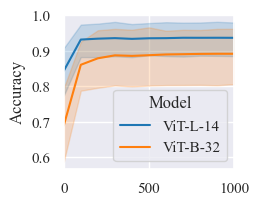

In [39]:
plot_data = []
_data = l14fusion_data_melted[l14fusion_data_melted["lr"] == "1e-3"]
_data["Model"] = "ViT-L-14"
plot_data.append(_data)
_data = b32fusion_data_melted[b32fusion_data_melted["lr"] == "1e-3"]
_data["Model"] = "ViT-B-32"
plot_data.append(_data)
plot_data = pd.concat(plot_data)

fig, ax = plt.subplots(figsize=(2.2, 2))
g = sns.lineplot(
    plot_data,
    x="step",
    y="Accuracy",
    hue="Model",
    palette=color_palette[:2],
    ax=ax,
)
g.legend_.set(loc="lower right")
ax.set_xlabel("")
ax.set_xlim((0, 1000))

plt.savefig("clip_b32_and_l14_acc.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_2570621/3921466230.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data["Model"] = "ViT-B-32"


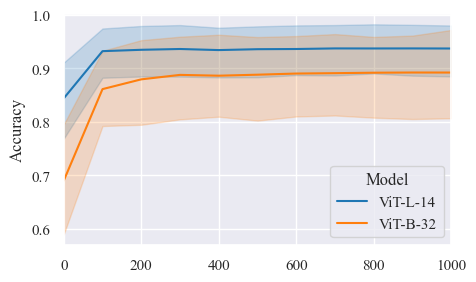

In [40]:
plot_data = []
_data = l14fusion_data_melted[l14fusion_data_melted["lr"] == "1e-3"]
_data["Model"] = "ViT-L-14"
plot_data.append(_data)
_data = b32fusion_data_melted[b32fusion_data_melted["lr"] == "1e-3"]
_data["Model"] = "ViT-B-32"
plot_data.append(_data)
plot_data = pd.concat(plot_data)

fig, ax = plt.subplots(figsize=(5, 3))
g = sns.lineplot(
    plot_data,
    x="step",
    y="Accuracy",
    hue="Model",
    palette=color_palette[:2],
    ax=ax,
)
g.legend_.set(loc="lower right")
ax.set_xlabel("")
ax.set_xlim((0, 1000))

plt.savefig("clip_b32_and_l14_acc_large.pdf", bbox_inches="tight")
plt.show()

# OOD Experiments

router ($l=0$)

In [65]:
model = "ViT-B-32"
router_0_data = []
for init_lambda in np.arange(0.1, 1.01, 0.1):
    for version, corruption in [
        (11, "Clean"),
        (12, "Motion Blur"),
        (13, "Impluse Noise"),
        (14, "Gaussian Noise"),
        (15, "Pixelate"),
        (16, "Spatter"),
        (17, "Contrast"),
        (17, "JPEG Compression"),
    ]:
        data_file = RESULTS_DIR / f"clip_dictmoe_init_lambda-{init_lambda:.1f}_router-0" / model / f"version_{version}" / "results.csv"
        df = pd.read_csv(data_file)
        df["scaling_coef"] = init_lambda
        df["corruption"] = corruption
        router_0_data.append(df)
b32router_0_data = pd.concat(router_0_data)

b32router_0_data_melt = b32router_0_data.melt(
    id_vars=["step", "corruption", "scaling_coef"],
    value_vars=["Cars", "EuroSAT", "RESISC45", "GTSRB"],
    var_name="Task",
    value_name="Accuracy",
)
b32router_0_data_melt

,step,corruption,scaling_coef,Task,Accuracy
0,1000,Clean,0.1,Cars,0.660987
1,500,Clean,0.1,Cars,0.662107
2,1000,Motion Blur,0.1,Cars,0.643577
3,500,Motion Blur,0.1,Cars,0.643328
4,500,Impluse Noise,0.1,Cars,0.621316
...,...,...,...,...,...
635,500,Spatter,1.0,GTSRB,0.710293
636,1000,Contrast,1.0,GTSRB,0.759382
637,500,Contrast,1.0,GTSRB,0.729216
638,1000,JPEG Compression,1.0,GTSRB,0.759382


router ($l=2$)

In [66]:
model = "ViT-B-32"
data = []
for init_lambda in np.arange(0.1, 1.01, 0.1):
    for version, corruption in [
        (11, "Clean"),
        (12, "Motion Blur"),
        (13, "Impluse Noise"),
        (14, "Gaussian Noise"),
        (15, "Pixelate"),
        (16, "Spatter"),
        (17, "Contrast"),
        (17, "JPEG Compression"),
    ]:
        data_file = RESULTS_DIR / f"clip_dictmoe_init_lambda-{init_lambda:.1f}_router-2" / model / f"version_{version}" / "results.csv"
        if data_file.exists():
            df = pd.read_csv(data_file)
        else:
            continue
        df["scaling_coef"] = init_lambda
        df["corruption"] = corruption
        data.append(df)
b32router_2_data = pd.concat(data)

b32router_2_data_melt = b32router_2_data.melt(
    id_vars=["step", "corruption", "scaling_coef"],
    value_vars=["Cars", "EuroSAT", "RESISC45", "GTSRB"],
    var_name="Task",
    value_name="Accuracy",
)
b32router_2_data_melt

,step,corruption,scaling_coef,Task,Accuracy
0,1000,Clean,0.1,Cars,0.781246
1,500,Clean,0.1,Cars,0.777018
2,1000,Motion Blur,0.1,Cars,0.769805
3,500,Motion Blur,0.1,Cars,0.766944
4,1000,Impluse Noise,0.1,Cars,0.743191
...,...,...,...,...,...
635,500,Spatter,1.0,GTSRB,0.920823
636,1000,Contrast,1.0,GTSRB,0.956770
637,500,Contrast,1.0,GTSRB,0.952652
638,1000,JPEG Compression,1.0,GTSRB,0.956770


load ties-merging and task arithmetic results

In [67]:
data = []
for corruption in ["None", "motion_blur", "impulse_noise", "gaussian_noise", "pixelate", "spatter", "contrast", "jpeg_compression"]:
    data_file = Path("results/ViT-B-32") / f"ties_merging-corruption={corruption}.csv"
    df = pd.read_csv(data_file)
    set_corruption(df, corruption)
    data.append(df)

b32ties_merging_data = pd.concat(data)
display(b32ties_merging_data)

data = []
for corruption in ["None", "motion_blur", "impulse_noise", "gaussian_noise", "pixelate", "spatter", "contrast", "jpeg_compression"]:
    data_file = Path("results/ViT-B-32") / f"task_arithmetic_corruption={corruption}.csv"
    df = pd.read_csv(data_file)
    set_corruption(df, corruption)
    data.append(df)

b32task_arithmetic_data = pd.concat(data)
display(b32task_arithmetic_data)

,scaling_coef,dataset,acc,corruption
0,0.0,Cars,0.597314,Clean
1,0.0,EuroSAT,0.458889,Clean
2,0.0,RESISC45,0.606667,Clean
3,0.0,GTSRB,0.326287,Clean
4,0.1,Cars,0.626166,Clean
...,...,...,...,...
39,0.9,GTSRB,0.755265,JPEG Compression
40,1.0,Cars,0.574307,JPEG Compression
41,1.0,EuroSAT,0.736296,JPEG Compression
42,1.0,RESISC45,0.775873,JPEG Compression


,scaling_coef,dataset,acc,corruption
0,0.0,Cars,0.597314,Clean
1,0.0,EuroSAT,0.458889,Clean
2,0.0,RESISC45,0.606667,Clean
3,0.0,GTSRB,0.326287,Clean
4,0.1,Cars,0.632135,Clean
...,...,...,...,...
39,0.9,GTSRB,0.664133,JPEG Compression
40,1.0,Cars,0.056585,JPEG Compression
41,1.0,EuroSAT,0.608889,JPEG Compression
42,1.0,RESISC45,0.546190,JPEG Compression


ViT-B/16 router depth is 0

In [68]:
model = "ViT-B-16"
router_0_data = []
for init_lambda in np.arange(0.1, 1.01, 0.1):
    for version, corruption in [
        (11, "Clean"),
        (12, "Motion Blur"),
        (13, "Impluse Noise"),
        (14, "Gaussian Noise"),
        (15, "Pixelate"),
        (16, "Spatter"),
        (17, "Contrast"),
        (17, "JPEG Compression"),
    ]:
        data_file = RESULTS_DIR / f"clip_dictmoe_init_lambda-{init_lambda:.1f}_router-0" / model / f"version_{version}" / "results.csv"
        df = pd.read_csv(data_file)
        df["scaling_coef"] = init_lambda
        df["corruption"] = corruption
        router_0_data.append(df)
b16router_0_data = pd.concat(router_0_data)

b16router_0_data_melt = b16router_0_data.melt(
    id_vars=["step", "corruption", "scaling_coef"],
    value_vars=["Cars", "EuroSAT", "RESISC45", "GTSRB"],
    var_name="Task",
    value_name="Accuracy",
)
b16router_0_data_melt

,step,corruption,scaling_coef,Task,Accuracy
0,1000,Clean,0.1,Cars,0.753513
1,500,Clean,0.1,Cars,0.746673
2,1000,Motion Blur,0.1,Cars,0.735729
3,500,Motion Blur,0.1,Cars,0.730879
4,1000,Impluse Noise,0.1,Cars,0.702773
...,...,...,...,...,...
635,500,Spatter,1.0,GTSRB,0.710530
636,1000,Contrast,1.0,GTSRB,0.802454
637,500,Contrast,1.0,GTSRB,0.776722
638,1000,JPEG Compression,1.0,GTSRB,0.802454


ViT-B/16 router depth is 2

In [69]:
model = "ViT-B-16"
data = []
for init_lambda in np.arange(0.1, 1.01, 0.1):
    for version, corruption in [
        (11, "Clean"),
        (12, "Motion Blur"),
        (13, "Impluse Noise"),
        (14, "Gaussian Noise"),
        (15, "Pixelate"),
        (16, "Spatter"),
        (17, "Contrast"),
        (17, "JPEG Compression"),
    ]:
        data_file = RESULTS_DIR / f"clip_dictmoe_init_lambda-{init_lambda:.1f}_router-2" / model / f"version_{version}" / "results.csv"
        if data_file.exists():
            df = pd.read_csv(data_file)
        else:
            continue
        df["scaling_coef"] = init_lambda
        df["corruption"] = corruption
        data.append(df)
b16router_2_data = pd.concat(data)

b16router_2_data_melt = b16router_2_data.melt(
    id_vars=["step", "corruption", "scaling_coef"],
    value_vars=["Cars", "EuroSAT", "RESISC45", "GTSRB"],
    var_name="Task",
    value_name="Accuracy",
)
b16router_2_data_melt

,step,corruption,scaling_coef,Task,Accuracy
0,1000,Clean,0.1,Cars,0.869419
1,500,Clean,0.1,Cars,0.867181
2,1000,Motion Blur,0.1,Cars,0.856983
3,500,Motion Blur,0.1,Cars,0.855988
4,1000,Impluse Noise,0.1,Cars,0.824400
...,...,...,...,...,...
635,500,Spatter,1.0,GTSRB,0.945527
636,1000,Contrast,1.0,GTSRB,0.968725
637,500,Contrast,1.0,GTSRB,0.960174
638,1000,JPEG Compression,1.0,GTSRB,0.968725


load B16 ties-merging and task arithmetic data

In [70]:
data = []
for corruption in ["None", "motion_blur", "impulse_noise", "gaussian_noise", "pixelate", "spatter", "contrast", "jpeg_compression"]:
    data_file = Path("results/ViT-B-16") / f"ties_merging-corruption={corruption}.csv"
    df = pd.read_csv(data_file)
    set_corruption(df, corruption)
    data.append(df)

b16ties_merging_data = pd.concat(data)
display(b16ties_merging_data)

data = []
for corruption in ["None", "motion_blur", "impulse_noise", "gaussian_noise", "pixelate", "spatter", "contrast", "jpeg_compression"]:
    data_file = Path("results/ViT-B-16") / f"task_arithmetic_corruption={corruption}.csv"
    df = pd.read_csv(data_file)
    set_corruption(df, corruption)
    data.append(df)

b16task_arithmetic_data = pd.concat(data)
display(b16task_arithmetic_data)

,scaling_coef,dataset,acc,corruption
0,0.0,Cars,0.646561,Clean
1,0.0,EuroSAT,0.542222,Clean
2,0.0,RESISC45,0.656984,Clean
3,0.0,GTSRB,0.433888,Clean
4,0.1,Cars,0.685736,Clean
...,...,...,...,...
39,0.9,GTSRB,0.738401,JPEG Compression
40,1.0,Cars,0.734237,JPEG Compression
41,1.0,EuroSAT,0.736296,JPEG Compression
42,1.0,RESISC45,0.847778,JPEG Compression


,scaling_coef,dataset,acc,corruption
0,0.0,Cars,0.646561,Clean
1,0.0,EuroSAT,0.542222,Clean
2,0.0,RESISC45,0.656984,Clean
3,0.0,GTSRB,0.433888,Clean
4,0.1,Cars,0.694068,Clean
...,...,...,...,...
39,0.9,GTSRB,0.671496,JPEG Compression
40,1.0,Cars,0.229822,JPEG Compression
41,1.0,EuroSAT,0.543333,JPEG Compression
42,1.0,RESISC45,0.656825,JPEG Compression


## plot

merge ViT-B/32 data

In [71]:
data = []
_data = b32router_0_data_melt[b32router_0_data_melt["step"] == 1000]
_data["Method"] = "WEMoE (l=0)"
data.append(_data)
_data = b32router_2_data_melt[b32router_2_data_melt["step"] == 1000]
_data["Method"] = "WEMoE (l=2)"
data.append(_data)
_data = b32ties_merging_data.rename(columns={"acc": "Accuracy", "dataset": "Task"})
_data["Method"] = "TIES-Merging"
data.append(_data)
_data = b32task_arithmetic_data.rename(columns={"acc": "Accuracy", "dataset": "Task"})
_data["Method"] = "Task Arithmetic"
data.append(_data)
data = pd.concat(data)

data = data[data['scaling_coef'] > 0]

/tmp/ipykernel_2570621/600786003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data["Method"] = "WEMoE (l=0)"
/tmp/ipykernel_2570621/600786003.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data["Method"] = "WEMoE (l=2)"


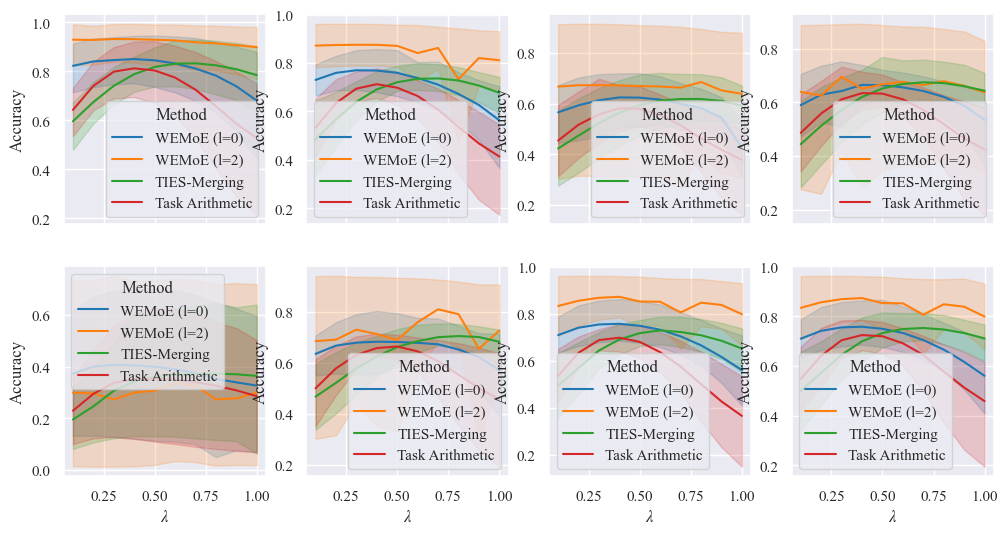

In [72]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True)


def plot_ax(ax: plt.Axes, data, corruption: str):
    plot_data = data[data["corruption"] == corruption]
    sns.lineplot(plot_data, x="scaling_coef", y="Accuracy", hue="Method", palette=color_palette[:4], ax=ax)
    ax.set_xlabel(r"$\lambda$")

    return ax


plot_ax(axes[0, 0], data, "Clean")
plot_ax(axes[0, 1], data, "Motion Blur")
plot_ax(axes[0, 2], data, "Impluse Noise")
plot_ax(axes[0, 3], data, "Gaussian Noise")
plot_ax(axes[1, 0], data, "Pixelate")
plot_ax(axes[1, 1], data, "Spatter")
plot_ax(axes[1, 2], data, "Contrast")
plot_ax(axes[1, 3], data, "JPEG Compression")

plt.show()

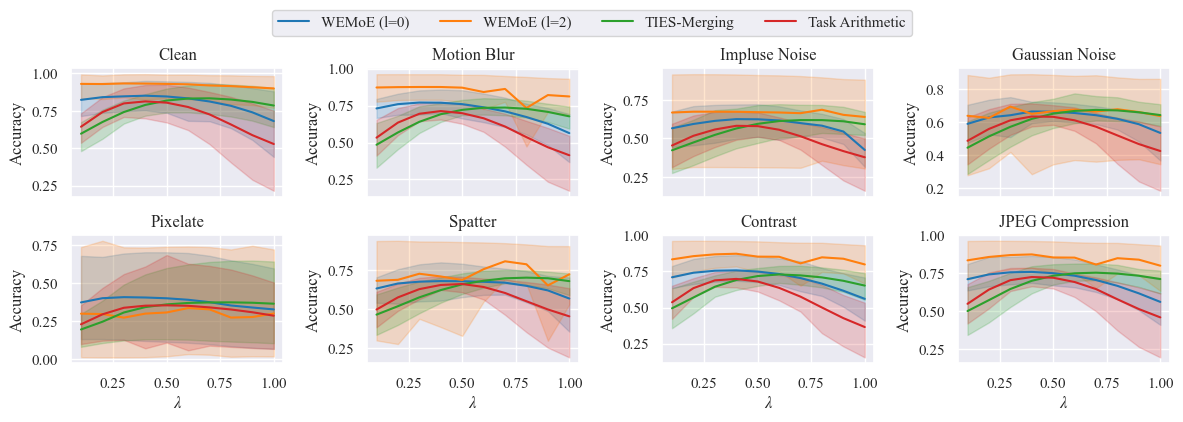

In [73]:
fig, axes = plt.subplots(2, 4, figsize=(12, 4), sharex=True)


def plot_ax(ax: plt.Axes, data, corruption: str, legend=False):
    plot_data = data[data["corruption"] == corruption]
    lines = sns.lineplot(plot_data, x="scaling_coef", y="Accuracy", hue="Method", palette=color_palette[:4], ax=ax, legend=legend)
    ax.set_xlabel(r"$\lambda$")
    ax.set_title(corruption)
    return lines


lines = plot_ax(axes[0, 0], data, "Clean", legend=True)
plot_ax(axes[0, 1], data, "Motion Blur")
plot_ax(axes[0, 2], data, "Impluse Noise")
plot_ax(axes[0, 3], data, "Gaussian Noise")
plot_ax(axes[1, 0], data, "Pixelate")
plot_ax(axes[1, 1], data, "Spatter")
plot_ax(axes[1, 2], data, "Contrast")
plot_ax(axes[1, 3], data, "JPEG Compression")

# Create a legend for the whole figure
labels = [t.get_text() for t in lines.get_legend().texts]
handles = lines.get_legend_handles_labels()[0]
fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.07))
lines.legend_.remove()

plt.tight_layout()
plt.savefig("b32_robustness.pdf", bbox_inches="tight")
plt.show()

merge b16 data

In [74]:
data = []
_data = b16router_0_data_melt[b16router_0_data_melt["step"] == 1000]
_data["Method"] = "WEMoE (l=0)"
data.append(_data)
_data = b16router_2_data_melt[b16router_2_data_melt["step"] == 1000]
_data["Method"] = "WEMoE (l=2)"
data.append(_data)
_data = b16ties_merging_data.rename(columns={"acc": "Accuracy", "dataset": "Task"})
_data["Method"] = "TIES-Merging"
data.append(_data)
_data = b16task_arithmetic_data.rename(columns={"acc": "Accuracy", "dataset": "Task"})
_data["Method"] = "Task Arithmetic"
data.append(_data)
data = pd.concat(data)

b16data = data[data["scaling_coef"] > 0]

/tmp/ipykernel_2570621/1720950853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data["Method"] = "WEMoE (l=0)"
/tmp/ipykernel_2570621/1720950853.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data["Method"] = "WEMoE (l=2)"


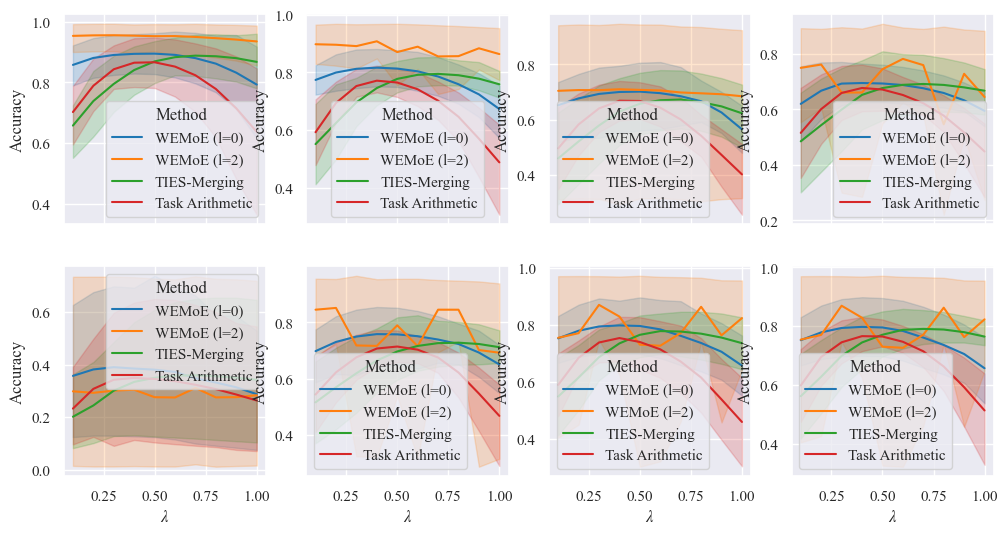

In [75]:
data = b16data
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True)


def plot_ax(ax: plt.Axes, data, corruption: str):
    plot_data = data[data["corruption"] == corruption]
    sns.lineplot(plot_data, x="scaling_coef", y="Accuracy", hue="Method", palette=color_palette[:4], ax=ax)
    ax.set_xlabel(r"$\lambda$")

    return ax


plot_ax(axes[0, 0], data, "Clean")
plot_ax(axes[0, 1], data, "Motion Blur")
plot_ax(axes[0, 2], data, "Impluse Noise")
plot_ax(axes[0, 3], data, "Gaussian Noise")
plot_ax(axes[1, 0], data, "Pixelate")
plot_ax(axes[1, 1], data, "Spatter")
plot_ax(axes[1, 2], data, "Contrast")
plot_ax(axes[1, 3], data, "JPEG Compression")

plt.show()

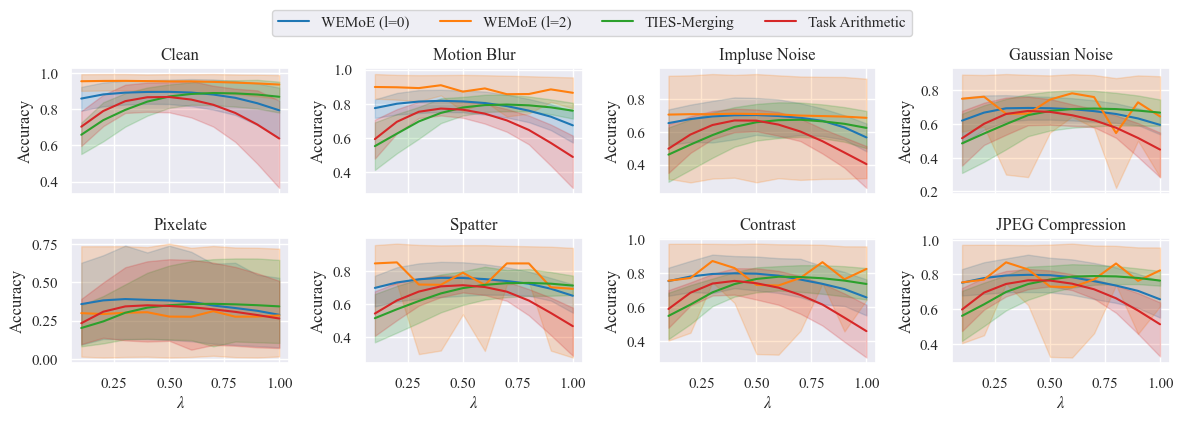

In [76]:
data = b16data
fig, axes = plt.subplots(2, 4, figsize=(12, 4), sharex=True)


def plot_ax(ax: plt.Axes, data, corruption: str, legend=False):
    plot_data = data[data["corruption"] == corruption]
    lines = sns.lineplot(plot_data, x="scaling_coef", y="Accuracy", hue="Method", palette=color_palette[:4], ax=ax, legend=legend)
    ax.set_xlabel(r"$\lambda$")
    ax.set_title(corruption)
    return lines


lines = plot_ax(axes[0, 0], data, "Clean", legend=True)
plot_ax(axes[0, 1], data, "Motion Blur")
plot_ax(axes[0, 2], data, "Impluse Noise")
plot_ax(axes[0, 3], data, "Gaussian Noise")
plot_ax(axes[1, 0], data, "Pixelate")
plot_ax(axes[1, 1], data, "Spatter")
plot_ax(axes[1, 2], data, "Contrast")
plot_ax(axes[1, 3], data, "JPEG Compression")

# Create a legend for the whole figure
labels = [t.get_text() for t in lines.get_legend().texts]
handles = lines.get_legend_handles_labels()[0]
fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.07))
lines.legend_.remove()

plt.tight_layout()
plt.savefig("b16_robustness.pdf", bbox_inches="tight")
plt.show()